(14392, 15)

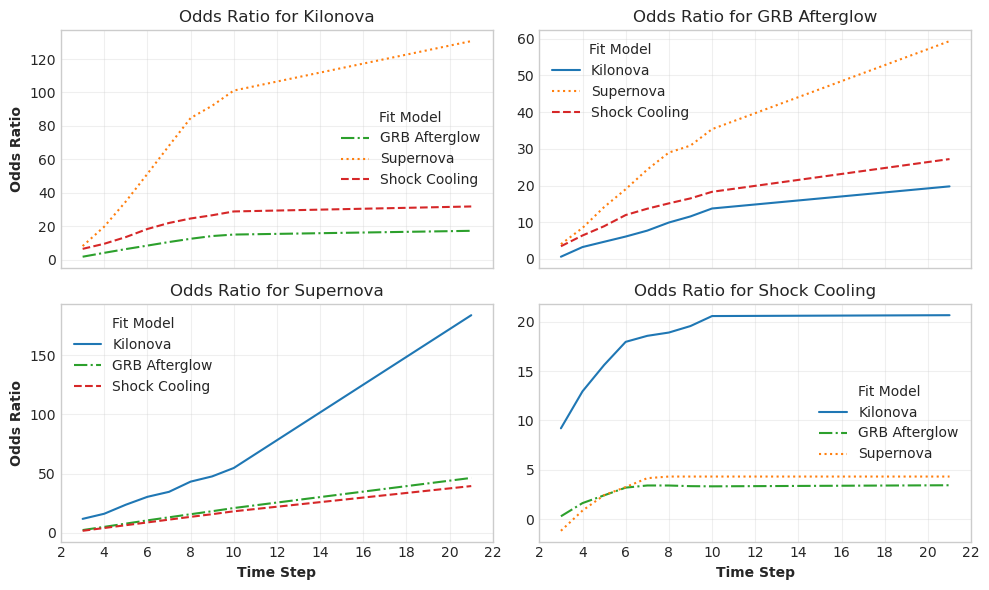

In [94]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
plt.style.context(("seaborn-colorblind",))
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
##plt.rcParams['font.size'] = 24
# plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['axes.titlesize'] = 24
# plt.rcParams['xtick.labelsize'] = 24
# plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['legend.fontsize'] = 24
# plt.rcParams['figure.titlesize'] = 24

df = pd.read_csv('./fit_dataframes/model-recovery-validated_fit_df.csv')
df21 = pd.read_csv('./fit_dataframes/21-validation-fit_df.csv')
df = pd.concat([df, df21], ignore_index=True)

model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

display(df.shape)

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'log_bayes_factor': 'median'}).reset_index()
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
#color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

fig, axs = plt.subplots(2, 2, figsize=(10, 6),sharex=True)
axs = axs.flatten()
model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# for axi, model in enumerate(grouped_df['true_model'].unique()):
for axi, model in enumerate(model_order):
    iter_df = grouped_df[grouped_df['true_model'] == model]
    
    ax = axs[axi]
    for fit_model in model_order:
        if fit_model != model:
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax.plot(diff_df['t_max'], diff, label=f'{model_dict[fit_model]}', color=color_dict[fit_model], linestyle=ls_dict[fit_model])
            ## plot above using lineplot instead of scatter
            #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')

    ax.set_title(f'Odds Ratio for {model_dict[model]}')
    ## grid lines
    ax.grid(True, alpha=0.3)

    ax.legend(title='Fit Model')
axs[0].set_ylabel('Odds Ratio'), axs[2].set_ylabel('Odds Ratio')
axs[2].set_xlabel('Time Step'), axs[3].set_xlabel('Time Step')
axs[0].set_xlim(2,22)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()


figpath = Path('./plots/odds_ratios_with21.pdf')
if not os.path.exists(figpath):
    plt.savefig(figpath, dpi=300)
else:
    input(f'{figpath} already exists. Press enter to overwrite.')
    plt.savefig(figpath, dpi=300)


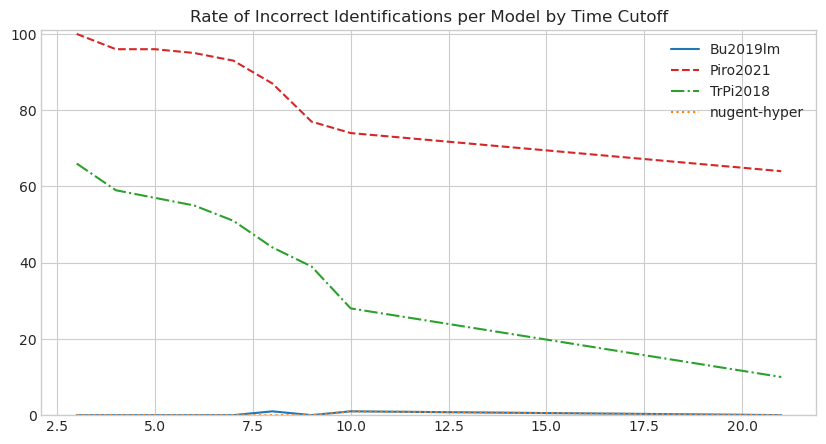

In [29]:
lowest_bayes = []
for lightcurve in  df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().min()].squeeze()
        lowest_bayes.append(lowest_bf_row )

lbf_df = pd.DataFrame(lowest_bayes)     


second_lowest_bayes = []
for lightcurve in df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        second_lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().sort_values().unique()[1]].squeeze()
        second_lowest_bayes.append(second_lowest_bf_row )
scnd_lbf_df = pd.DataFrame(second_lowest_bayes)

## plot the number of incorrect idenfications per model, grouped by t_max (x-axis)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for model in lbf_df['true_model'].unique():
    model_df = lbf_df[(lbf_df['true_model'] == model)]
    ## count number of incorrect identifications per t_max per model
    incorrect_identifications = []
    for tmax in sorted(model_df['t_max'].unique()):
        tmax_df = model_df[model_df['t_max'] == tmax]
        incorrect_identifications.append(len(tmax_df[tmax_df['fit_model'] != model]))
    ax.plot(sorted(model_df['t_max'].unique()), incorrect_identifications, label=model, linestyle=ls_dict[model], color=color_dict[model])
    ax.legend()
    ax.set_ylim(0, 101)
ax.set_title('Rate of Incorrect Identifications per Model by Time Cutoff')
plt.show()


## from lbf_df, find percentage per model of incorrect identifications, grouped by t_max. there are 100 lightcurves for each model

# for tmax in sorted(lbf_df['t_max'].unique()):
#     print(f'\nFor t_max: {tmax}')
#     for model in lbf_df['true_model'].unique():
#         model_df = lbf_df[(lbf_df['true_model'] == model) & (lbf_df['t_max'] == tmax)]
#         print(f'For true model: {model}, the percentage of incorrect identifications is: {round(len(model_df[model_df["fit_model"] != model]) / len(model_df)*100,1)}')

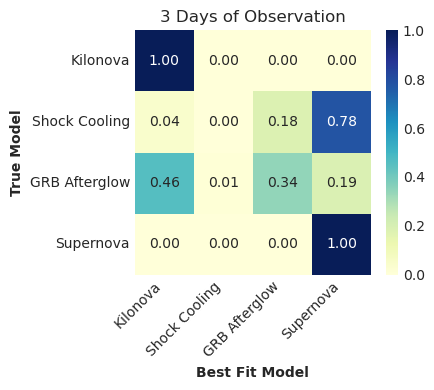

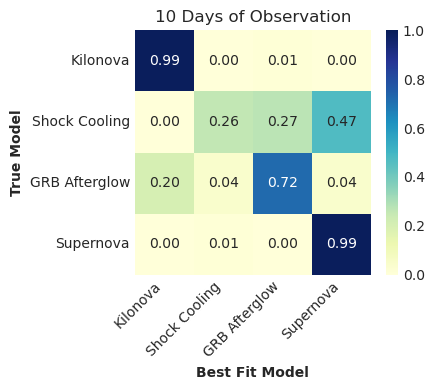

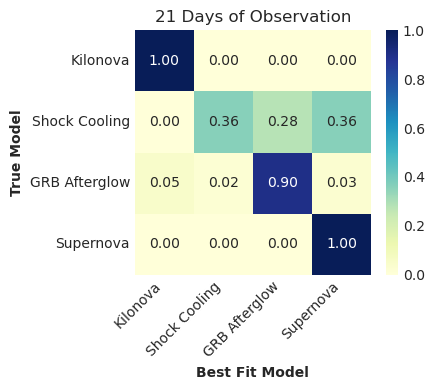

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

model_dict = {
    'Bu2019lm': 'Kilonova',
    'TrPi2018': 'GRB Afterglow',
    'Piro2021': 'Shock Cooling',
    'nugent-hyper': 'Supernova'
}

# for tmax in sorted(lbf_df['t_max'].unique()):
for tmax in sorted([3,10,21]):
    try:
        tmax_df = lbf_df[lbf_df['t_max'] == tmax]
        
        
        # Create the heatmap data and replace the index/column names using model_dict
        heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
        heatmap_data = heatmap_data.apply(lambda x: x / x.sum(), axis=1)
        heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)

        # Create the heatmap
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",  norm=Normalize(vmin=0, vmax=1), ax=ax)

        # Set the title for the axes
        ax.set_title(f'{int(tmax)} Days of Observation')

        # Set the new labels for the axes
        ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
        ax.set_yticklabels(heatmap_data.index, rotation=0)
        ax.set_xlabel('Best Fit Model')
        ax.set_ylabel('True Model')
        
        fig.tight_layout()
        plt.show()
    except:
        continue


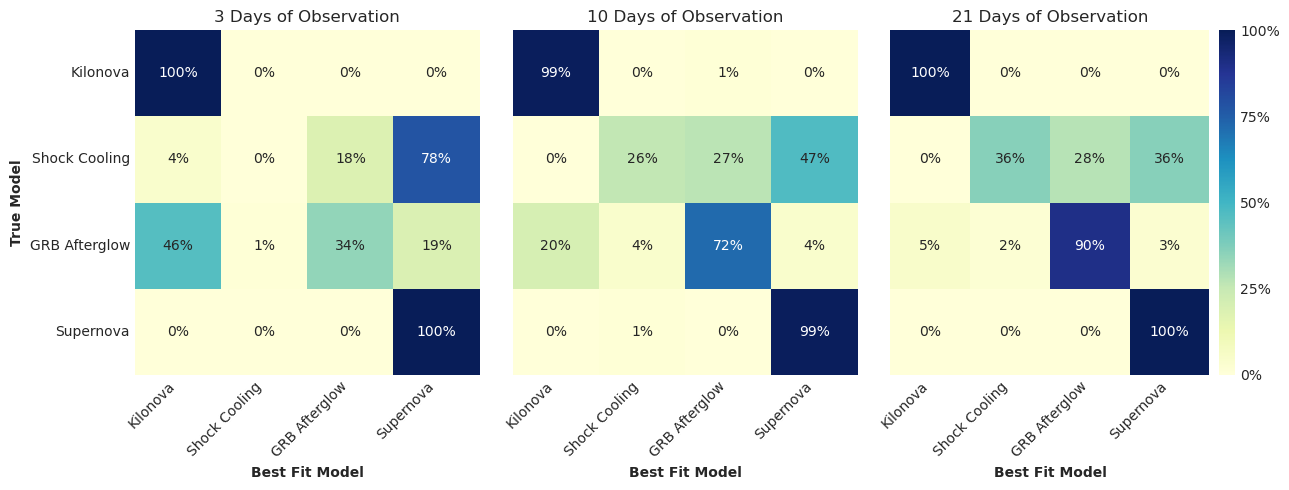

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

model_dict = {
    'Bu2019lm': 'Kilonova',
    'TrPi2018': 'GRB Afterglow',
    'Piro2021': 'Shock Cooling',
    'nugent-hyper': 'Supernova'
}

fig, axes = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

## Iterate over the sorted unique values of t_max and create a subplot for each
for i, tmax in enumerate(sorted([3,10,21])):
    tmax_df = lbf_df[lbf_df['t_max'] == tmax]
    heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
    ## Normalize the data by the row sums and multiply by 100 for percentage
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0).multiply(100)
    heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)
    
    ## Generate annotation data with percentage signs
    annotations = heatmap_data.applymap("{:.0f}%".format)
    
    ax = axes[i]
    sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="YlGnBu", norm=Normalize(vmin=0, vmax=100), ax=ax, cbar=i == 2,
                cbar_ax=None if i != 2 else make_axes_locatable(axes[i]).append_axes("right", size="5%", pad=0.1))
    
    ax.set_title(f'{int(tmax)} Days of Observation')
    ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
    ax.set_xlabel('Best Fit Model')
    
    ## Only add y labels to the leftmost plot
    if i == 0:
        ax.set_yticklabels(heatmap_data.index, rotation=0)
        ax.set_ylabel('True Model')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
## Adjust for the colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
fig.tight_layout()

figpath = Path('./plots/conf_matrix_combined.pdf')
if not os.path.exists(figpath):
    plt.savefig('./plots/conf_matrix_combined.pdf', dpi=300)
else:
    input(f'{figpath} already exists. Press enter to overwrite.')
    plt.savefig('./plots/conf_matrix_combined.pdf', dpi=300)

In [34]:
scnd_lbf_df[scnd_lbf_df['true_model']=='Piro2021']
p21_lbf_df = lbf_df[lbf_df['true_model']=='Piro2021']
p21_scnd_lbf_df = scnd_lbf_df[scnd_lbf_df['true_model']=='Piro2021']
for tmax in sorted(p21_scnd_lbf_df['t_max'].unique()):
    iter_df = p21_scnd_lbf_df[p21_scnd_lbf_df['t_max'] == tmax]
    ## count how many per timestep have fit_model == true_model
    print(f'For t_max: {tmax}, the percentage of identifications where Piro2021 is the second best model is: {round(len(iter_df[iter_df["fit_model"] == iter_df["true_model"]]) / len(iter_df)*100,1)}')

For t_max: 3.0, the percentage of identifications where Piro2021 is the second best model is: 75.0
For t_max: 4.0, the percentage of identifications where Piro2021 is the second best model is: 76.0
For t_max: 5.0, the percentage of identifications where Piro2021 is the second best model is: 79.0
For t_max: 6.0, the percentage of identifications where Piro2021 is the second best model is: 79.0
For t_max: 7.0, the percentage of identifications where Piro2021 is the second best model is: 76.0
For t_max: 8.0, the percentage of identifications where Piro2021 is the second best model is: 71.0
For t_max: 9.0, the percentage of identifications where Piro2021 is the second best model is: 62.0
For t_max: 10.0, the percentage of identifications where Piro2021 is the second best model is: 59.0
For t_max: 21.0, the percentage of identifications where Piro2021 is the second best model is: 50.0


In [35]:
## for each the piro2021 lightcurves in p21_lbf_df and p21_scnd_lbf_df at each timestep where the value of true_model is not Piro2021 in lbf_df, plot the difference between the log_bayes_factor in p21_lbf_df and p21_scnd_lbf_df

for tmax in sorted(p21_scnd_lbf_df['t_max'].unique()):
    iter_first_df = p21_lbf_df[p21_lbf_df['t_max'] == tmax]
    iter_scnd_df = p21_scnd_lbf_df[p21_scnd_lbf_df['t_max'] == tmax]
    ## calculate median difference in log_bayes_factor for each lightcurve
    odds_ratio = []
    first_bf = []
    first_model = []
    scnd_bf = []
    scnd_model = []
    odds_ratio_lcs = []
    num_correct = 0
    num_total = 0
    num_scnd_correct = 0
    print(f'\nFor t_max = {tmax}:')
    for lc in iter_first_df['lightcurve'].unique():
        first_df = iter_first_df[iter_first_df['lightcurve'] == lc]
        scnd_df = iter_scnd_df[iter_scnd_df['lightcurve'] == lc]
        num_total += 1
        if scnd_df['fit_model'].values[0] == 'Piro2021':
            num_scnd_correct += 1
        if first_df['fit_model'].values[0] == 'Piro2021':
            # print('for lightcurve: ', lc, 'the first best model is Piro2021')
            num_correct += 1
            continue
        elif scnd_df['fit_model'].values[0] != 'Piro2021':
            continue
        else:
            # print(first_df['fit_model'].values[0])
            first_bf.append(first_df['log_bayes_factor'].values[0])
            scnd_bf.append(scnd_df['log_bayes_factor'].values[0])
            first_model.append(first_df['fit_model'].values[0])
            scnd_model.append(scnd_df['fit_model'].values[0])
            odds_ratio_lcs.append(lc)
            odds_ratio.append(first_df['log_bayes_factor'].values[0] - scnd_df['log_bayes_factor'].values[0])
    
    print(f'Median odds ratio: {np.median(odds_ratio)}')
    #print('number of lightcurves with positive odds ratio: ', len([i for i in odds_ratio if i > 0]))
    print('number of correct identifications: ', num_correct)
    print('number where Piro2021 is the second best model: ', num_scnd_correct)
    print('number of total lightcurves: ', num_total)
    print('percent of misidentifications where the second best model is Piro2021: ', round(num_scnd_correct / (num_total-num_correct) * 100, 1))
    ## print models for which the odds ratio is negative
    # print('models for which the odds ratio is negative: ', [model for model in scnd_model if model != 'Piro2021'])


For t_max = 3.0:
Median odds ratio: 1.1222157914478466
number of correct identifications:  0
number where Piro2021 is the second best model:  75
number of total lightcurves:  100
percent of misidentifications where the second best model is Piro2021:  75.0

For t_max = 4.0:
Median odds ratio: 1.3450103904431803
number of correct identifications:  4
number where Piro2021 is the second best model:  76
number of total lightcurves:  100
percent of misidentifications where the second best model is Piro2021:  79.2

For t_max = 5.0:
Median odds ratio: 1.3229946346325825
number of correct identifications:  4
number where Piro2021 is the second best model:  79
number of total lightcurves:  100
percent of misidentifications where the second best model is Piro2021:  82.3

For t_max = 6.0:
Median odds ratio: 1.2788331064880545
number of correct identifications:  5
number where Piro2021 is the second best model:  79
number of total lightcurves:  100
percent of misidentifications where the second be